<a href="https://colab.research.google.com/github/offthewallace/CSE584/blob/main/classcifier_4class%2Bsentencedata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

# Specify the path where you want to save the model in Google Drive
save_directory = '/content/drive/MyDrive/longformer_model_sentence'

df = pd.read_csv('/content/drive/MyDrive/sentence_complete_4class.csv')

# Encode LLM labels ('gpt2', 'gpt-neo') into numerical labels (0, 1)
label_encoder = LabelEncoder()
df['llm_label'] = label_encoder.fit_transform(df['llm'])

# Split the data into train and test sets
train_xi, test_xi, train_xj, test_xj, train_labels, test_labels = train_test_split(
    df['xi'].values, df['xj'].values, df['llm_label'].values, test_size=0.2, random_state=42
)

# Convert inputs to lists of strings
train_xi = [str(x) if x is not None else '' for x in train_xi]
train_xj = [str(x) if x is not None else '' for x in train_xj]
test_xi = [str(x) if x is not None else '' for x in test_xi]
test_xj = [str(x) if x is not None else '' for x in test_xj]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
# Load Longformer tokenizer and model

import torch

# Clear the CUDA cache
torch.cuda.empty_cache()

#tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')  # Model supports up to 4096 tokens
#model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=4)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # 2 classes: gpt2 (0) and gpt-neo (1)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the input with a maximum length of 1024 tokens
def tokenize_pairs_longformer(tokenizer, xi_list, xj_list):
    return tokenizer(
        xi_list,
        xj_list,
        truncation=True,
        padding=True,
        max_length=512,  # Set max_length to 1024 tokens
        return_tensors='pt'
    )

# Ensure input is valid and tokenize the inputs
train_encodings = tokenize_pairs_longformer(tokenizer, train_xi, train_xj)
test_encodings = tokenize_pairs_longformer(tokenizer, test_xi, test_xj)

# You can use the same training and evaluation process

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the return

In [12]:
torch.save(train_encodings, '/content/drive/My Drive/train_encodings.pt')
torch.save(test_encodings, '/content/drive/My Drive/test_encodings.pt')

In [15]:
from torch.utils.data import Dataset, DataLoader
import torch

# Create a PyTorch dataset for the paired input
class TextPairDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextPairDataset(train_encodings, train_labels)
test_dataset = TextPairDataset(test_encodings, test_labels)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [16]:
# Move model to GPU if available
from transformers import LongformerTokenizer, LongformerForSequenceClassification, AdamW
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training function
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    return correct / total

# Train for a few epochs
epochs = 1
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer)
    accuracy = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-15-8d84ebaed30c>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 500/500 [09:28<00:00,  1.14s/it]


Epoch 1, Train Loss: 0.1201, Test Accuracy: 0.9735


In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Specify the path where you want to save the model in Google Drive
save_directory = '/content/drive/My Drive/bert_model'

# Save the trained model's weights
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/My Drive/bert_model


In [ ]:
torch.cuda.empty_cache()

100%|██████████| 250/250 [00:33<00:00,  7.55it/s]


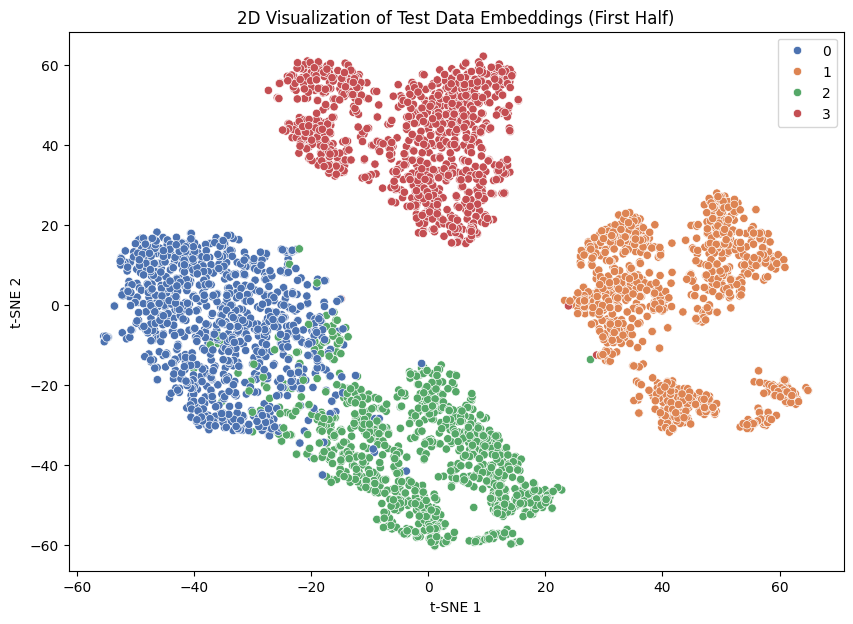

In [29]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import LongformerTokenizer, LongformerForSequenceClassification

# Switch model to evaluation mode

load_directory = '/content/drive/My Drive/bert_model'

# Load the model and tokenizer from Google Drive

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # 2 classes: gpt2 (0) and gpt-neo (1)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained(load_directory)
tokenizer = BertTokenizer.from_pretrained(load_directory)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


model.eval()
# Use only the first half of the test data to reduce memory usage
half_size = len(test_xi) // 2
test_xi_half = test_xi[:half_size]
test_xj_half = test_xj[:half_size]
test_labels_half = test_labels[:half_size]

# Define batch size for processing
batch_size = 16  # Adjust this value based on available GPU memory
num_batches = int(np.ceil(len(test_xi_half) / batch_size))

# List to store all embeddings
all_hidden_states = []

# Process the test data in batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(test_xi_half))

    # Tokenize the current batch
    test_encodings = tokenizer(
        test_xi_half[start_idx:end_idx],
        test_xj_half[start_idx:end_idx],
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Move the input data to the appropriate device
    input_ids = test_encodings['input_ids'].to(device)
    attention_mask = test_encodings['attention_mask'].to(device)

    # Extract the embeddings from the model
    with torch.no_grad():
        outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # Get the last layer's hidden states
        all_hidden_states.append(hidden_states.mean(dim=1).cpu().numpy())  # Store the embeddings for this batch

# Combine all embeddings from all batches
hidden_states_np = np.concatenate(all_hidden_states, axis=0)

# Apply t-SNE to reduce the embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(hidden_states_np)

# Visualize the embedding space using the first half of the test labels
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=test_labels_half, palette='deep', legend='full')
plt.title('2D Visualization of Test Data Embeddings (First Half)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [30]:
df['llm_label']

,llm_label
0,2
1,2
2,2
3,2
4,2
...,...
39995,3
39996,3
39997,3
39998,3


In [31]:
df['llm']

,llm
0,gpt2
1,gpt2
2,gpt2
3,gpt2
4,gpt2
...,...
39995,qwen-2-0.5B
39996,qwen-2-0.5B
39997,qwen-2-0.5B
39998,qwen-2-0.5B
